In [320]:
import numpy as np
import plotly.graph_objs as pgo # For Plotting isosurfaces
import matplotlib.pyplot as plt # For other plotting

In [321]:
# Load in and reshape data
sub_data = np.load('./subdata.npy') # Loads in flattened array of 3D data
sub_data.shape

(262144, 49)

In [322]:
# Define Normal Space Parameters
L = 10 # Length of side
N = 64 # Size of grid in each direction
x = np.linspace(-L, L, N+1) # spatial x grid
x = x[:-1] # Take first N points
y = x; z = x # Same discretation in other dimensions
x_grid, y_grid, z_grid = np.meshgrid(x, y, z) # Generate meshgrid

In [323]:
# Define Fourier Space Parameters
# NOTE: Take out -1 from fourier vector as numpy doesn't include upper endpoint
kx = 2 * np.pi/(2 * L) * np.hstack((np.arange(0, N/2), np.arange(-N/2, 0))) # Define base kx vector, fourier order
kx = np.fft.fftshift(kx) # Apply fftshift for proper order of items
ky = kx; kz = kx # Same fourier discretation in all dimensions
kx_grid, ky_grid, kz_grid = np.meshgrid(kx, ky, kz)

In [324]:
# Calculate FFT of each time step
sub_data_fft = np.zeros((N, N, N, sub_data.shape[1]), dtype='complex_') # Need to allow for complex values
for i in range(sub_data.shape[1]): # Iterate through all 3D slices
    sub_signal = np.reshape(sub_data[:, i], (N, N, N), 'F')
    sub_signal_fft = np.fft.fftn(sub_signal)
    sub_data_fft[:,:,:,i] = np.fft.fftshift(sub_signal_fft) # Add each element to result

In [325]:
# Average data to remove noise
sub_data_fft_sum = np.sum(sub_data_fft, axis=3) # Sum across last axis
average_frequencies = np.abs(sub_data_fft_sum) / np.abs(sub_data_fft_sum.flatten()).max() # Normalize frequencies

In [326]:
# Get location of max frequency
max_idx = np.argmax(average_frequencies.flatten())
x_loc, y_loc, z_loc = np.unravel_index(max_idx, sub_data_fft_sum.shape) # Linear index to matrix form (column major)
x_freq = kx_grid[x_loc, y_loc, z_loc].flatten() # Extract x frequency(ies)
y_freq = ky_grid[x_loc, y_loc, z_loc].flatten() # Extract y frequency(ies)
z_freq = kz_grid[x_loc, y_loc, z_loc].flatten() # Extract z frequency(ies)
print(x_loc, y_loc, z_loc) # Print Locations
print(x_freq, y_freq, z_freq) # Print frequencies

54 15 25
[-5.34070751] [6.91150384] [-2.19911486]


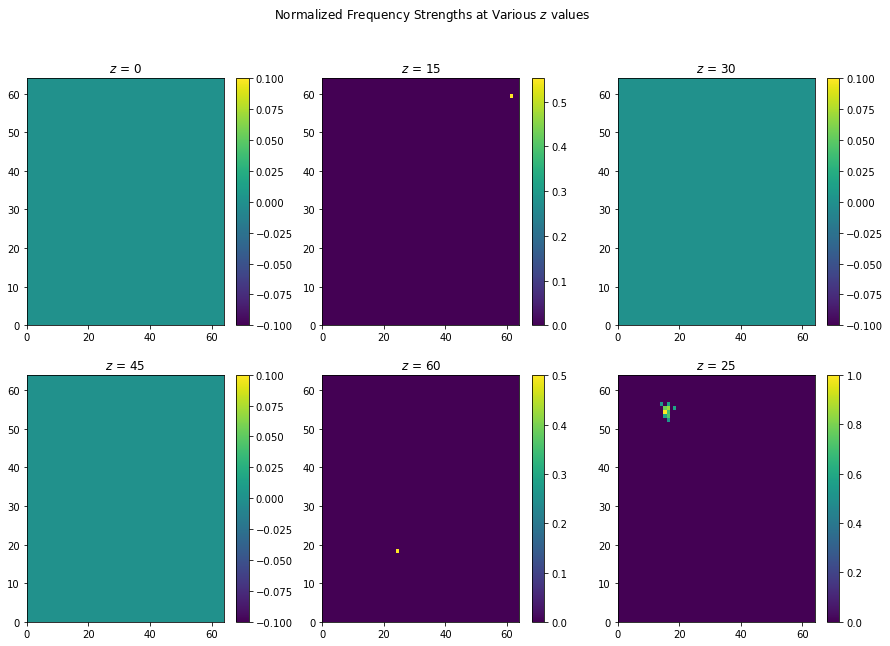

In [327]:
# Plot colormesh for max_idx
plot_idxs = [0, 15, 30, 45, 60, z_loc]
fig = plt.figure(figsize=(15, 10))

for i in range(1, len(plot_idxs) + 1):
    plt.subplot(2, len(plot_idxs) // 2, i)
    fft_plot = average_frequencies[:, :, plot_idxs[i-1]] # Data to Plot
    fft_plot = fft_plot * (fft_plot >= 0.5) # Filter down to the higher frequencies
    f = plt.pcolormesh(fft_plot)
    plt.colorbar(f)
    plt.title('$z$ = ' + str(plot_idxs[i-1]))

plt.suptitle('Normalized Frequency Strengths at Various $z$ values')
plt.show()

In [328]:
# Create Gaussian Filter using central frequency
gauss_filt = np.exp(-0.1 * ((kx_grid - x_freq[0])**2  + (ky_grid - y_freq[0])**2 + (kz_grid - z_freq[0])**2))

In [329]:
# Use Gaussian filter to de-noise and locate the data
position_data = np.zeros((sub_data.shape[1], 3)) # For storing locations
for i in range(sub_data.shape[1]): # Iterate through data
    sub_loc_fft = sub_data_fft[:, :, :, i] # Access the FFT data (already shifted)
    sub_loc_fft_filt = sub_loc_fft * gauss_filt # Apply filter
    sub_loc_fft_filt = np.fft.ifftshift(sub_loc_fft_filt) # Shift data back
    sub_loc_filt = np.fft.ifftn(sub_loc_fft_filt) # inverse transform
    sub_loc_norm = np.abs(sub_loc_filt) / np.abs(sub_loc_filt.flatten()).max()
    freq_location = np.argmax(sub_loc_norm.flatten()) # Find flattened index of main
    x_loc, y_loc, z_loc = np.unravel_index(freq_location, sub_loc_norm.shape) # Get indexes
    x_loc, y_loc, z_loc = x_grid[x_loc, y_loc, z_loc], y_grid[x_loc, y_loc, z_loc], z_grid[x_loc, y_loc, z_loc] # Get locations
    position_data[i, :] = [x_loc, y_loc, z_loc] # Append

print(position_data.T) # Print Data

[[ 3.125   3.125   3.125   3.125   3.125   3.125   3.125   3.125   3.125
   2.8125  2.8125  2.5     2.1875  1.875   1.875   1.5625  0.9375  0.625
   0.3125  0.     -0.625  -0.9375 -1.25   -1.875  -2.1875 -2.8125 -3.125
  -3.75   -4.0625 -4.375  -4.6875 -5.3125 -5.625  -5.9375 -5.9375 -6.25
  -6.5625 -6.875  -6.875  -6.875  -6.875  -6.875  -6.5625 -6.5625 -6.25
  -6.25   -5.9375 -5.3125 -5.3125]
 [ 0.      0.3125  0.625   0.9375  1.5625  1.875   2.1875  2.5     2.8125
   3.125   3.4375  3.75    4.0625  4.375   4.6875  5.      5.      5.
   5.3125  5.625   5.625   5.625   5.9375  5.9375  5.9375  5.9375  5.9375
   5.9375  5.9375  5.9375  5.625   5.625   5.3125  5.3125  5.      5.
   4.6875  4.375   4.0625  3.75    3.4375  3.4375  2.8125  2.5     2.1875
   1.875   1.5625  1.25    0.9375]
 [-8.125  -7.8125 -7.5    -7.1875 -6.875  -6.5625 -6.25   -5.9375 -5.625
  -5.3125 -5.     -4.6875 -4.375  -4.0625 -3.75   -3.4375 -3.125  -2.8125
  -2.5    -2.1875 -1.875  -1.5625 -1.25   -1.25   -0.9375 

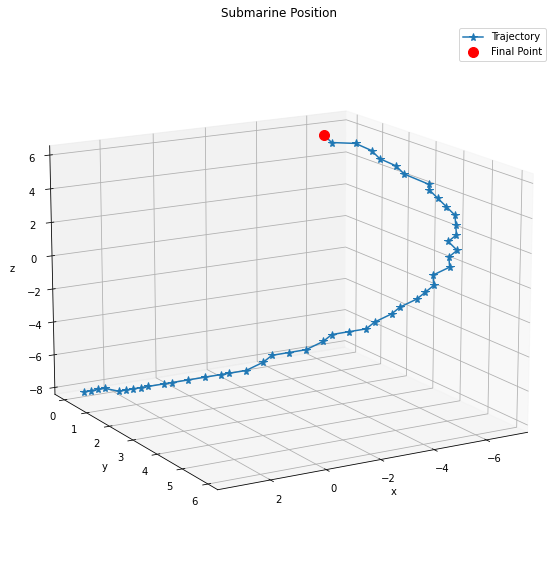

In [330]:
# Plot 3D Position
fig = plt.figure(figsize=(10,10)) # Generate subplots

# 3D Position Plot
ax0 = plt.axes(projection='3d');
ax0.plot(position_data[:, 0], position_data[:, 1], position_data[:, 2], '-*',
        markersize=8, label='Trajectory')
plt.plot(position_data[-1, 0], position_data[-1, 1], position_data[-1, 2],
        'ro', markersize=10, label='Final Point')
ax0.set_xlabel('x'); ax0.set_ylabel('y'); ax0.set_zlabel('z')
ax0.autoscale() # Autoscale axes
ax0.set_title('Submarine Position')
ax0.view_init(15,60)

# Show/Save Plot
plt.legend()
plt.savefig('3D_Sub_Location.png', bbox_inches='tight')
plt.show()

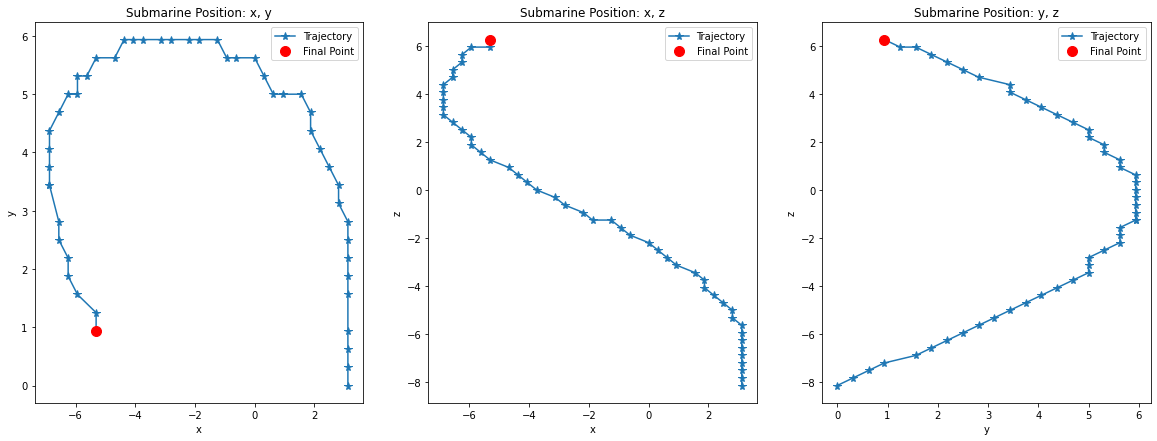

In [331]:
# 2D Projections
fig = plt.figure(figsize=(20, 7))

# x, y position
plt.subplot(1,3,1)
plt.plot(position_data[:, 0], position_data[:, 1], '-*', 
         label='Trajectory', markersize=8)
plt.plot(position_data[-1, 0], position_data[-1, 1], 'ro', 
         label='Final Point', markersize=10)
plt.xlabel('x'); plt.ylabel('y');
plt.title('Submarine Position: x, y')
plt.legend()

# x, z position
plt.subplot(1,3,2)
plt.plot(position_data[:, 0], position_data[:, 2], '-*', 
         label='Trajectory', markersize=8)
plt.plot(position_data[-1, 0], position_data[-1, 2], 'ro', 
         label='Final Point', markersize=10)
plt.xlabel('x'); plt.ylabel('z');
plt.title('Submarine Position: x, z')
plt.legend()

# y, z position
plt.subplot(1,3,3)
plt.plot(position_data[:, 1], position_data[:, 2], '-*', 
         label='Trajectory', markersize=8)
plt.plot(position_data[-1, 1], position_data[-1, 2], 'ro', 
         label='Final Point', markersize=10)
plt.xlabel('y'); plt.ylabel('z');
plt.title('Submarine Position: y, z')
plt.legend()

# Show Plot
plt.savefig('2D_Sub_Locations.png', bbox_inches='tight')
plt.show()